<a href="https://colab.research.google.com/github/tuongkhangduongle/brainMRI_segmentation/blob/main/brain_tumor_segmentation_Unetplusplus_pytorch_version.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!nvidia-smi

Mon Jun 28 13:14:55 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   55C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp '/content/drive/MyDrive/REPORT/CourseProject/CS338/archive.zip' '/content/archive.zip'

In [ ]:
!unzip -q './archive.zip'

# Lib

In [ ]:
import numpy as np 
import pandas as pd
import glob
import os
import cv2
import torch
import torchvision
from torchvision import utils as vutils
from torchvision import transforms
from torch import nn
from torch.nn import functional as F
from torch.utils import data
from torch.optim import SGD, Adam
from PIL import Image
import matplotlib.pyplot as plt
import os
from tqdm import tqdm_notebook

from torch.optim import lr_scheduler


# EDA

In [ ]:
root = './lgg-mri-segmentation/kaggle_3m'

no_mask = 0
no_mask_files = []
no_file = 0
no_files = []
num_empty_masks = 0
num_nonempty_masks = 0

S = 3 # number of pos/neg samples to take
empty_mask_samples = []
nonempty_mask_samples = []

img_dimensions = []
msk_dimensions = []

n_files = 0
for directory in [os.path.join(root,x) for x in os.listdir(root) if os.path.isdir(os.path.join(root, x))]:
    for file in os.listdir(directory):
        n_files += 1
        img_dimensions.append(np.array(cv2.imread(os.path.join(directory, file))).shape)
        #count files with no mask
        if 'mask' not in file:
            #check if mask exists
            mask_path = os.path.join(directory, file[:file.find('.tif')]+'_mask.tif')
            if not os.path.exists(mask_path):
                no_mask += 1
                no_mask_files.append(os.path.join(directory, file))
        else:
            msk_dimensions.append(np.array(cv2.imread(os.path.join(directory, file), cv2.IMREAD_UNCHANGED)).shape)
            #count masks with no file
            f_path = os.path.join(directory, file[:file.find('mask')-1]+'.tif')
            #check if file exists
            if not os.path.exists(f_path):
                no_file += 1
                no_files.append(os.path.join(directory, file))
                
            #check if mask is empty
            j = np.max(cv2.imread(os.path.join(directory, file), cv2.IMREAD_UNCHANGED))
            if j > 0:
                num_nonempty_masks += 1
                if len(nonempty_mask_samples) < S:
                    nonempty_mask_samples.append(os.path.join(directory, file))
            else:
                num_empty_masks += 1
                if len(empty_mask_samples) < S:
                    empty_mask_samples.append(os.path.join(directory, file))

In [ ]:
#check variance in dimensions
print('Image Dimensions')
print(len(set(img_dimensions)))
print(set(img_dimensions))
print('Mask Dimensions')
print(len(set(msk_dimensions)))
print(set(msk_dimensions))

Image Dimensions
1
{(256, 256, 3)}
Mask Dimensions
1
{(256, 256)}


#No Mask: 0
#Mask w/ No File: 0
#Total Files 7858


<BarContainer object of 2 artists>

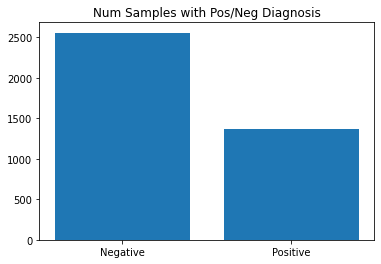

In [ ]:
print(f'#No Mask: {no_mask}')
print(f'#Mask w/ No File: {no_file}')
print(f'#Total Files {n_files}')

plt.figure()
plt.title('Num Samples with Pos/Neg Diagnosis')
plt.bar([0,1], [num_empty_masks, num_nonempty_masks], tick_label=['Negative', 'Positive'])

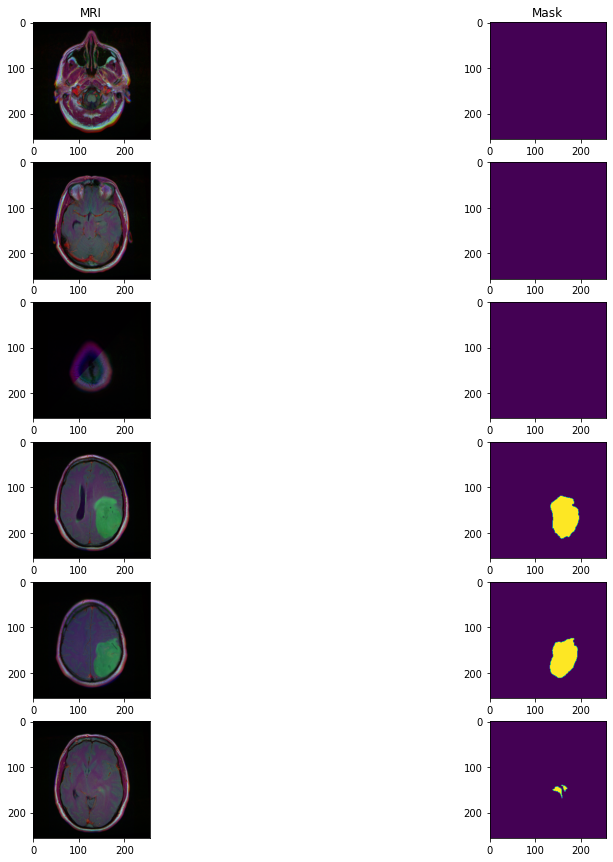

In [ ]:
#display images of negative and positive samples - negative samples have an empty mask
fig, axs = plt.subplots(6,2, figsize=(15,15))
for ax, col in zip(axs[0], ['MRI', 'Mask']):
    ax.set_title(col)
    
display_imgs = empty_mask_samples+nonempty_mask_samples #concat lists for easy plotting
#print(display_imgs)
for i in range(len(display_imgs)):
    mask_path = display_imgs[i]
    img_path = mask_path[:mask_path.find('mask')-1]+'.tif'
    axs[i,0].imshow(np.array(cv2.imread(img_path)))
    axs[i,1].imshow(np.array(cv2.imread(mask_path, cv2.IMREAD_UNCHANGED)))

In [ ]:
#store list of train files for dataset creation of the form (train_img, mask_img, pos_neg_result(1/0))
#these tuples are fed into the datasets we create below
file_list = []
for directory in [os.path.join(root,x) for x in os.listdir(root) if os.path.isdir(os.path.join(root, x))]:
    for file in os.listdir(directory):
        #add files to list
        if 'mask' not in file:
            result = 0
            img_path = os.path.join(directory, file)
            mask_path = os.path.join(directory, file[:file.find('.tif')]+'_mask.tif')
                
            #check if mask is nonempty
            if np.max(cv2.imread(mask_path, cv2.IMREAD_UNCHANGED)) > 0:
                result = 1
            
            file_list.append([img_path, mask_path, result])
            

# EDA V2

In [ ]:
brain_df = pd.read_csv('/content/lgg-mri-segmentation/kaggle_3m/data.csv')

In [ ]:
dirr = "/content/lgg-mri-segmentation/kaggle_3m/"

image_size = 256

data = []

for sub_dir_path in glob.glob(dirr + "*"):
    if os.path.isdir(sub_dir_path):
        dirname = sub_dir_path.split("/")[-1]
        for filename in os.listdir(sub_dir_path):
            image_path = sub_dir_path + "/" + filename
            data.extend([dirname, image_path])
        
        
df = pd.DataFrame(
    {
        "dirname" : data[::2],
        "path" : data[1::2]
    }
)

In [ ]:
df_no_masks = df[~df['path'].str.contains("mask")]
df_masks = df[df['path'].str.contains("mask")]

no_masks = sorted(df_no_masks["path"].values, key=lambda string: int(string.split('.')[0].split('_')[-1]))
masks = sorted(df_masks["path"].values, key=lambda string: int(string.split('.')[0].split('_')[-2]))

In [ ]:
df = pd.DataFrame(
    {
        'patient': df_no_masks['dirname'].values,
        'image_path': no_masks,
        'mask_path': masks
    }
)

In [ ]:
'''
mask > 0: ảnh segment có chứa khối u và ngược lại.
'''

diagnos = lambda path: 1 if np.max(cv2.imread(path)) > 0 else 0

df["diagnosis"] = df["mask_path"].apply(diagnos)

In [ ]:
df['diagnosis'].value_counts() / df.shape[0]

0    0.650547
1    0.349453
Name: diagnosis, dtype: float64

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X_train, X_test = train_test_split(df, stratify=df['diagnosis'], test_size=0.15, random_state=42)
X_train, X_valid = train_test_split(X_train, stratify=X_train['diagnosis'], test_size=0.5, random_state=42)

X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
X_valid = X_valid.reset_index(drop=True)

print(X_train['diagnosis'].value_counts() / X_train.shape[0])
print(X_valid['diagnosis'].value_counts() / X_valid.shape[0])
print(X_test['diagnosis'].value_counts() / X_test.shape[0])

0    0.650689
1    0.349311
Name: diagnosis, dtype: float64
0    0.650299
1    0.349701
Name: diagnosis, dtype: float64
0    0.650847
1    0.349153
Name: diagnosis, dtype: float64


# Creat Segmentation Class

In [ ]:
from torch.utils.data import Dataset

In [ ]:
class Brain_MRI_Segmentation_Dataset(Dataset):
    def __init__(self, inputs, transform=None):
        self.inputs = inputs
        self.transform = transform
        self.input_dtype = torch.float32
        self.target_dtype = torch.float32
        
    def __len__(self):
        return len(self.inputs)
    
    def __getitem__(self, index):
        #for classification return only the image and the binary label
        img_path = self.inputs[index][0]
        mask_path = self.inputs[index][1]
        #mask_img = cv2.normalize(cv2.imread(mask_path), None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
        mask_img = cv2.imread(mask_path, cv2.IMREAD_UNCHANGED)
        x = torch.from_numpy(np.transpose(np.array(cv2.imread(img_path)), (2,0,1))).type(self.input_dtype)
        y = torch.from_numpy(np.resize(np.array(mask_img)/255., (1,256,256))).type(self.target_dtype)
        
        if self.transform is not None:
            x = self.transform(x)
            y = self.transform(y)
        
        return x,y

# Custom Metric

In [ ]:
def iou_pytorch(outputs: torch.Tensor, labels: torch.Tensor, threshold=0.5):
    # You can comment out this line if you are passing tensors of equal shape
    # But if you are passing output from UNet or something it will most probably
    # be with the BATCH x 1 x H x W shape
    SMOOTH = 1e-6
    outputs = outputs.squeeze(1)  # BATCH x 1 x H x W => BATCH x H x W
    labels = labels.squeeze(1)
    
    bin_out = torch.where(outputs > threshold, 1, 0).type(torch.int16)
    labels = labels.type(torch.int16)
    
    intersection = (bin_out & labels).float().sum((1, 2))  # Will be zero if Truth=0 or Prediction=0
    union = (bin_out | labels).float().sum((1, 2))         # Will be zero if both are 0
    
    iou = (intersection + SMOOTH) / (union + SMOOTH)  # We smooth our division to avoid 0/0
    
    thresholded = torch.clamp(20 * (iou - 0.5), 0, 10).ceil() / 10  # This is equal to comparing with thresolds
    
    return thresholded.mean()  # Or thresholded.mean() if you are interested in average across the batch

In [ ]:
def dice_loss(logits, true, eps=1e-7):
    """Computes the Sørensen–Dice loss.
    Note that PyTorch optimizers minimize a loss. In this
    case, we would like to maximize the dice loss so we
    return the negated dice loss.
    Args:
        true: a tensor of shape [B, 1, H, W].
        logits: a tensor of shape [B, C, H, W]. Corresponds to
            the raw output or logits of the model.
        eps: added to the denominator for numerical stability.
    Returns:
        dice_loss: the Sørensen–Dice loss.
    """
    num_classes = logits.shape[1]
    if num_classes == 1:
        true_1_hot = torch.eye(num_classes + 1)[true.long().squeeze(1)]
        true_1_hot = true_1_hot.permute(0, 3, 1, 2).float()
        true_1_hot_f = true_1_hot[:, 0:1, :, :]
        true_1_hot_s = true_1_hot[:, 1:2, :, :]
        true_1_hot = torch.cat([true_1_hot_s, true_1_hot_f], dim=1)
        pos_prob = torch.sigmoid(logits)
        neg_prob = 1 - pos_prob
        probas = torch.cat([pos_prob, neg_prob], dim=1)
    else:
        true_1_hot = torch.eye(num_classes)[true.long().squeeze(1)]
        true_1_hot = true_1_hot.permute(0, 3, 1, 2).float()
        probas = F.softmax(logits, dim=1)
    true_1_hot = true_1_hot.type(logits.type())
    dims = (0,) + tuple(range(2, true.ndimension()))
    intersection = torch.sum(probas * true_1_hot, dims)
    cardinality = torch.sum(probas + true_1_hot, dims)
    dice_loss = (2. * intersection / (cardinality + eps)).mean()
    return (1 - dice_loss)

In [ ]:
def bce_dice_loss(output, target):
    bce = nn.BCEWithLogitsLoss()
    return bce(output, target) + dice_loss(output, target)

In [ ]:
def tversky_loss( true, logits, alpha =0.7, beta=0.3, eps=1e-7):
    
    num_classes = logits.shape[1]
    if num_classes == 1:
        true_1_hot = torch.eye(num_classes + 1)[true.squeeze(1)]
        true_1_hot = true_1_hot.permute(0, 3, 1, 2).float()
        true_1_hot_f = true_1_hot[:, 0:1, :, :]
        true_1_hot_s = true_1_hot[:, 1:2, :, :]
        true_1_hot = torch.cat([true_1_hot_s, true_1_hot_f], dim=1)
        pos_prob = torch.sigmoid(logits)
        neg_prob = 1 - pos_prob
        probas = torch.cat([pos_prob, neg_prob], dim=1)
    else:
        true_1_hot = torch.eye(num_classes)[true.squeeze(1)]
        true_1_hot = true_1_hot.permute(0, 3, 1, 2).float()
        probas = F.softmax(logits, dim=1)

    true_1_hot = true_1_hot.type(logits.type())
    dims = (0,) + tuple(range(2, true.ndimension()))
    intersection = torch.sum(probas * true_1_hot, dims)
    fps = torch.sum(probas * (1 - true_1_hot), dims)
    fns = torch.sum((1 - probas) * true_1_hot, dims)
    num = intersection
    denom = intersection + (alpha * fps) + (beta * fns)
    tversky_loss = (num / (denom + eps)).mean()
    
    return (1 - tversky_loss)

In [ ]:
def focal_tversky_loss(true, logits, alpha =0.7, beta=0.3, eps=1e-7):
    pt_1 = tversky_loss(true, logits)
    gamma = 0.7
    return pt_1**gamma

In [ ]:
def focal_tversky_loss(inputs, targets, smooth=1, alpha=0.7, beta=0.3, gamma=0.75):
    
    #comment out if your model contains a sigmoid or equivalent activation layer
    inputs = F.sigmoid(inputs)       
    
    #flatten label and prediction tensors
    inputs = inputs.view(-1)
    targets = targets.view(-1)
    
    #True Positives, False Positives & False Negatives
    TP = (inputs * targets).sum()    
    FP = ((1-targets) * inputs).sum()
    FN = (targets * (1-inputs)).sum()
    
    Tversky = (TP + smooth) / (TP + alpha*FP + beta*FN + smooth)  
    FocalTversky = (1 - Tversky)**gamma
                    
    return FocalTversky

# Augmentation

In [ ]:
transform = transforms.Compose([
    transforms.RandomAffine(degrees=15, translate=(0.1, 0.1), scale=(0.8, 0.8))
])


# Data Loader

In [ ]:
positive_diagnoses = [x for x in file_list if x[2] == 1]

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
train, val = train_test_split(positive_diagnoses, test_size = 0.15, random_state = 42)
test, val = train_test_split(val, test_size = 0.5, random_state = 42)

In [ ]:
train_set = Brain_MRI_Segmentation_Dataset(train)
val_set = Brain_MRI_Segmentation_Dataset(val)
test_set = Brain_MRI_Segmentation_Dataset(test) 


train_loader = data.DataLoader(dataset=train_set, batch_size=8, shuffle=True)
val_loader = data.DataLoader(dataset=val_set, batch_size=8, shuffle=False)
test_loader = data.DataLoader(dataset=test_set, batch_size=8, shuffle=False)

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
len(train_loader)

146

# Unet++ Architecture

In [ ]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ConvBlock, self).__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
    
    def forward(self, x):
        return self.block(x)

class DownConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DownConv, self).__init__()
        self.sequence = nn.Sequential(
            ConvBlock(in_channels, out_channels),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
    def forward(self, x):
        return self.sequence(x)
        
class UpConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UpConv, self).__init__()
        self.sequence = nn.Sequential(
            nn.ConvTranspose2d(in_channels, in_channels, kernel_size=2, stride=2),
            ConvBlock(in_channels, out_channels)
        )
        
    def forward(self, x):
        return self.sequence(x)
        
class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1):
        super(UNet, self).__init__()
        #input_dim = 256
        self.encoder = nn.ModuleList([
            DownConv(in_channels, 64), #128
            DownConv(64, 128), #64
            DownConv(128, 256), #32
            DownConv(256, 512) #16
        ])
        
        self.bottleneck = ConvBlock(512, 1024)
        
        #extra channels allow for concatenation of skip connections in upsampling block
        self.decoder = nn.ModuleList([
            UpConv(512+1024,512), #32
            UpConv(256+512,256), #64
            UpConv(128+256,128), #128
            UpConv(64+128,64) #256
        ])
        
        self.output_conv = nn.Conv2d(64, out_channels, kernel_size=1)
        
    def forward(self, x):
        skips = []
        o = x
        for layer in self.encoder:
            o = layer(o)
            skips.append(o)
        
        o = self.bottleneck(o)
        
        for i, layer in enumerate(self.decoder):
            #print(o.size())
            o = torch.cat((skips[len(skips)-i-1],o), dim=1)
            #print(o.size())
            o = layer(o)
        
        return self.output_conv(o)

In [ ]:
class UNetPlusPlus(nn.Module):
    def __init__(self, input_channels=3, output_channels=1, depth=5):
        super(UNetPlusPlus, self).__init__()
        self.depth = depth
        self.output_channels = output_channels
        self.conv_map = nn.ModuleDict({})
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        
        #construct all convolution blocks
        #sums in input channels account for concatenated skip connections from previous j nodes
        for i in range(self.depth):
            for j in range(self.depth-i):
                if i == 0 and j == 0:
                    self.conv_map[str((i,j))] = ConvBlock(in_channels=input_channels, out_channels=32)
                #elif i == 0:
                 #   self.conv_map[(i,j)] = ConvBlock(in_channels=(32*j)+64, out_channels=32)
                elif j == 0:
                    self.conv_map[str((i,j))] = ConvBlock(in_channels=32*(2**(i-1)), out_channels=32*(2**i))
                else:
                    self.conv_map[str((i,j))] = ConvBlock(in_channels=((32*(2**i))*j)+32*(2**(i+1)), out_channels=32*(2**i))
                    
        #implement 1x1 convolutions which enable us to compute completed segmentation maps at the supervised nodes:
        #X_0,j; j ={1,2,3,...,depth-1}
            
        self.output_convs = nn.ModuleList()
        for j in range(depth-1):
            self.output_convs.append(nn.Conv2d(32, output_channels, kernel_size=1))

    def forward(self, x):
        outputs = {}
        for j in range(self.depth):
            for i in range(self.depth-j):
                #X_0,0 takes the input image
                if i == 0 and j == 0:
                    outputs[(i,j)] = self.conv_map[str((i,j))](x)
                #X_i,0 convolves over the downsampled output of the previous convolution in the backbone
                elif j == 0:
                    outputs[(i,j)] = self.conv_map[str((i,j))]( self.pool(outputs[(i-1,j)]) )
                else:
                    #concatenate all skip connections from same row
                    concats = outputs[(i,0)]
                    for j_ in range(1,j):
                        concats = torch.cat((outputs[(i,j_)], concats), dim=1)
                        
                    #concatenate upsampled output from lower depth to skip connections
                    concats = torch.cat( (concats, self.upsample(outputs[(i+1,j-1)])), dim=1 )
                    
                    outputs[(i,j)] = self.conv_map[str((i,j))](concats)
        
        #compute averaged output
        dev = 'cuda' if torch.cuda.is_available() else 'cpu'
        averaged_output = torch.zeros(x.size()[0], self.output_channels, x.size()[2], x.size()[3], requires_grad=True, device=dev)
        for j in range(1,self.depth):
            averaged_output =  averaged_output + self.output_convs[j-1](outputs[(0,j)])
        
        averaged_output = averaged_output / (self.depth-1)
        
        return averaged_output

# Full Training

In [ ]:
#train model
#batch -
#N,3,256,256
#N,1,256,256

def run_experiment(model_name, model, optimizer, criterion, train_loader, val_loader, device='cuda', num_epochs=50, clear_mem=True):
    
    #######################
    #Train model          #
    #######################
    print('Model sent to ' + str(device))
    model.to(device)
    losses = []
    train_scores = [] # hold IoU scores
    iters = 0
    for epoch in range(num_epochs):
        if epoch % 10 == 0:
            print(f'Epoch {epoch+1}/{num_epochs}')
        
        for i,batch in enumerate(train_loader):
            img = batch[0].to(device)
            msk = batch[1].to(device)

            optimizer.zero_grad()
            output = model(img)
            loss = criterion(output, msk)
            loss.backward()
            optimizer.step()

            losses.append(loss.item())
            train_scores.append(iou_metric(output.detach(), msk))

            iters += 1

            #if iters % 500 == 0:
                #print(f'Loss: [{loss}]')
                
    #for i in range(len(train_scores)):
     #   train_scores[i] = train_scores[i].mean()
        
    #######################
    #Validate model       #
    #######################
    
    model.eval()
    val_losses = []
    val_scores = []

    for i,batch in enumerate(val_loader):
            img = batch[0].to(device)
            msk = batch[1].to(device)

            output = model(img)
            loss = criterion(output, msk)
            val_scores.append(iou_pytorch(output.detach(), msk))
            val_losses.append(loss.item())
            
    results = {
        'model_name': model_name,
        'train_losses': losses,
        'train_scores': train_scores,
        'val_losses': val_losses,
        'val_scores': val_scores
    }
    
    if clear_mem:
        del model
        del optimizer
        del criterion
        torch.cuda.empty_cache()
        
    return results

In [ ]:
def plot_training_scores(losses, train_scores):
    #plot loss and IoU
    fig, axs = plt.subplots(1,2, figsize=(5,5))
    axs[0].set_title('Train BCE Loss')
    axs[0].plot(range(len(losses)), losses)

    axs[1].set_title('IoU Score vs Training Step')
    axs[1].plot(range(len(train_scores)), train_scores)

def plot_validation_scores(val_losses, val_scores):
    #plot loss and IoU scores - we use a histogram because we care about the distribution of losses, not its progression
    fig, axs = plt.subplots(1,2, figsize=(7,7))
    axs[0].set_title('BCE Loss on Validation Set')
    axs[0].hist(val_losses)

    temp = [t.cpu().item() for t in val_scores]
    axs[1].set_title('IoU Scores on Validation Set')
    axs[1].hist(temp)
    axs[1].axvline(np.median(np.array(temp)), color='k', linestyle='dashed', linewidth=1)

def visualize_segmentation(model, data_loader, num_samples=5, device='cuda'):
    #visualize segmentation on unseen samples
    fig, axs = plt.subplots(num_samples, 3, figsize=(60,60))

    for ax, col in zip(axs[0], ['MRI', 'Ground Truth', 'Predicted Mask']):
        ax.set_title(col)

    index = 0
    for i,batch in enumerate(data_loader):
            img = batch[0].to(device)
            msk = batch[1].to(device)

            output = model(img)

            for j in range(batch[0].size()[0]): #iterate over batchsize
                axs[index,0].imshow(np.transpose(img[j].detach().cpu().numpy(), (1,2,0)).astype(np.uint8), cmap='bone', interpolation='none')

                axs[index,1].imshow(np.transpose(img[j].detach().cpu().numpy(), (1,2,0)).astype(np.uint8), cmap='bone', interpolation='none')
                axs[index,1].imshow(torch.squeeze(msk[j]).detach().cpu().numpy(), cmap='Blues', interpolation='none', alpha=0.5)

                axs[index,2].imshow(np.transpose(img[j].detach().cpu().numpy(), (1,2,0)).astype(np.uint8), cmap='bone', interpolation='none')
                axs[index,2].imshow(torch.squeeze(output[j]).detach().cpu().numpy(), cmap='Greens', interpolation='none', alpha=0.5)

                index += 1

            if index >= num_samples:
                break

    plt.tight_layout()

# Training phase

In [ ]:
num_epochs = 60
model = UNetPlusPlus()
optimizer = Adam(model.parameters(), lr=0.05, eps= 0.1)
scheduler = lr_scheduler.MultiplicativeLR(optimizer, lr_lambda=lambda epoch: 0.9)
criterion = focal_tversky_loss

In [ ]:
results = run_experiment('Unet++_AugmentedData_CE-DiceLoss', model, optimizer, criterion, train_loader, val_loader, device=device, num_epochs=num_epochs, clear_mem=False)

Model sent to cuda
Epoch 1/60


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 11/60
Epoch 21/60
Epoch 31/60
Epoch 41/60
Epoch 51/60


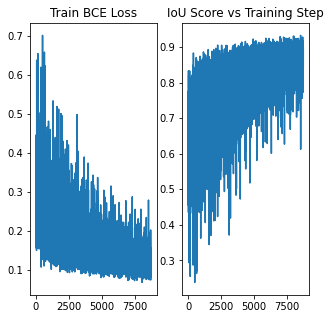

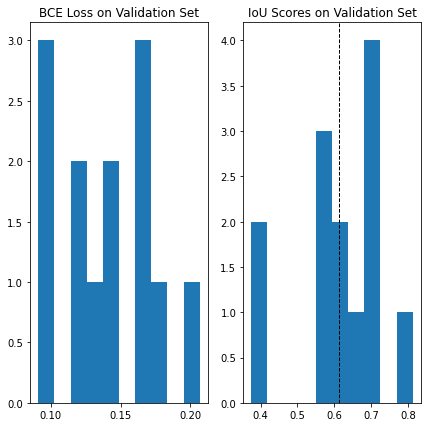

In [ ]:
plot_training_scores(results['train_losses'], results['train_scores'])
plot_validation_scores(results['val_losses'], results['val_scores'])

In [ ]:
torch.save(model.state_dict(), f'weight.pt')

In [ ]:
!cp 'weight.pt' '/content/drive/MyDrive/REPORT/adam_unetpp.pt'

# Evaluate

In [ ]:
!cp  '/content/drive/MyDrive/REPORT/50epochs_adam_weight_unetpp.pt' 'weight.pt'

In [ ]:
model.load_state_dict(torch.load('./weight.pt'))

<All keys matched successfully>

In [ ]:
device = 'cuda'
model.to(device)

UNetPlusPlus(
  (conv_map): ModuleDict(
    ((0, 0)): ConvBlock(
      (block): Sequential(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=True)
      )
    )
    ((0, 1)): ConvBlock(
      (block): Sequential(
        (0): Conv2d(96, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5)

In [ ]:
def iou_metric(inputs, targets):
    inputs = F.sigmoid(inputs)       
        
    #flatten label and prediction tensors
    inputs = inputs.view(-1)
    targets = targets.view(-1)
    smooth = 1
    #intersection is equivalent to True Positive count
    #union is the mutually inclusive area of all labels & predictions 
    intersection = (inputs * targets).sum()
    total = (inputs + targets).sum()
    union = total - intersection 
    
    IoU = (intersection + smooth)/(union + smooth)

    return IoU

In [ ]:
model.eval()

test_scores = []

for i,batch in enumerate(test_loader):
        img = batch[0].to(device)
        msk = batch[1].to(device)

        output = model(img)
        loss = criterion(output, msk)
        test_scores.append(iou_metric(output.detach(), msk))
        

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


In [ ]:
test_sc = 0
for sc in test_scores:
    test_sc += sc.item()

test_sc /= len(test_scores)